# Federated learning: regression for a 2D simple case

The present notebook tackles the problem of assessing the accuracy of a specific model into a federated configuration. 
In this case, we will create a learning model from scratch and show how to make it interact with the Federated Learning platform. 
In particular, we assess the *accuracy* in a federated learning context, and we address the *privacy level needed* in terms of sampling the sensitivity of our model.

## Model definition
In order to make our model interact with the Federated Learning platform we will simply need to define:
1. How to load the data;
2. The model.

In the following, each step is described for the case of a 2D linear regression model. 

**How to load the data**\
A method that returns train, test and validation data need to be provided, wrapping it in the class `data_base`.\
Typically, existing data is used. 
However, in this example a series of 2D points is created for simplicity:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shfl
from shfl.data_base import data_base as db

# Create database: 
class LinearRegressionDB(db.DataBase):
    
    def __init__(self):
        self._beta0 = 10    # True linear coefficients
        self._beta1 = 2     # True linear coefficients
        self._scale = 10    # Noise added to the true linear regression
        self._size_train = 80
        self._size_test = 20
        self._size_validation = 20
        
    def _create_data(self, size_data):
        data = np.random.randint(low = 0, high=100, size=size_data, dtype='l')
        labels = self._beta0 + self._beta1*data + np.random.normal(loc=0.0, scale=self._scale, size=len(data))
        
        return(data, labels) 
       
    def load_data(self):
        self._train_data, self._train_labels = self._create_data(self._size_train)
        self._test_data, self._test_labels = self._create_data(self._size_test)
        self._validation_data, self._validation_labels = self._create_data(self._size_validation)
        
        return self.data

database = LinearRegressionDB()
train_data, train_labels, val_data, val_labels, test_data, test_labels = database.load_data()
print(len(train_data))
print(len(val_data))
print(len(test_data))

Using TensorFlow backend.


80
20
20


**Define the model** <br/>
Now we just need to define the model, which needs to be wrapped in the class `TrainableModel`. 
Abstract methods from class `TrainableModel` need to be defined, i.e. we must provide functions for `train`, `predict`, `evaluate`, `get_parameters` and `set_parameters`. 
In the case of 2D linear regression, a possible implementation is the following:

In [2]:
from shfl.model import TrainableModel

class LinearRegression2D(TrainableModel):
    
    def __init__(self, beta0 = 0.0, beta1=0.0):
        self._beta0 = beta0
        self._beta1 = beta1
        
    def train(self, data, labels):
        """
        In the case of 2D linear regression, a closed formula can be used.
        """
        data_mean = np.mean(data)
        labels_mean = np.mean(labels)
        beta1 = np.sum( np.multiply((data-data_mean), (labels-labels_mean)) ) / np.sum( np.square((data-data_mean)) )
        beta0 = labels_mean - beta1*data_mean
        self._beta0 = beta0
        self._beta1 = beta1
        
    def predict(self, data):
        y_predicted = self._beta0 + self._beta1 * data
        
        return(y_predicted)
    
    def evaluate(self, data, labels):
        """
        Add here all the metrics to evaluate the performance. 
        """
        prediction = self.predict(data)
        error = np.square(labels - prediction)
        RMSE = np.sqrt(error.mean())
        MAPE = np.abs(np.divide(error, labels)).mean() 
        
        return RMSE, MAPE 

    def get_model_params(self):
        return (self._beta0, self._beta1)
    
    def set_model_params(self, params):
        self._beta0 = params[0]
        self._beta1 = params[1]

We can graphically check that our implementation is correct:

Regression coefficients: (11.265587524436086, 1.9828774075699342)
Performance metrics: (10.282028541391849, 3.2067611434931207)


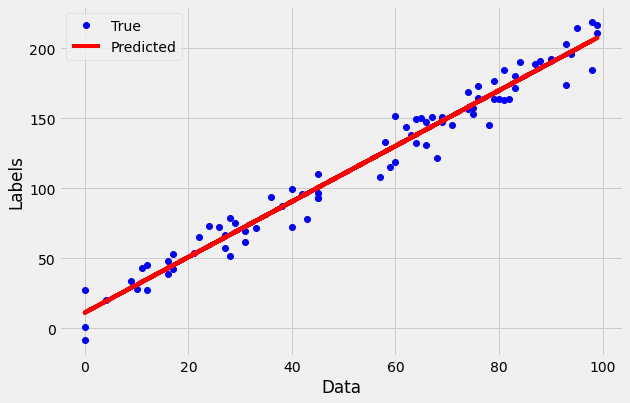

In [3]:
# Plot the regression over the train data:
LR = LinearRegression2D()
LR.train(data = train_data, labels = train_labels)
print("Regression coefficients: " + str((LR._beta0, LR._beta1)))
print("Performance metrics: " + str(LR.evaluate(data = train_data, labels = train_labels)))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(train_data, train_labels, 'bo', label = "True")
ax.plot(train_data, LR.predict(data = train_data), label = "Predicted", color = "red")
ax.set_xlabel('Data')
ax.set_ylabel('Labels')
plt.legend(title = "")
plt.show()

## Running the model in a Federated configuration
After defining the data and the model, we are ready to run our model in a federated configuration. 
We distribute the data over the nodes, assuming the data is IID.
Next, we define the aggregation of the federated outputs to be the average. 
In this case, we set the number of rounds `n=1` since no iterations are needed in this specific case of 2D linear regression. \
It can be observed that the performance of *Global model* is in general superior with respect to the performance of each node, thus the federated learning approach proves to be beneficial.  

In [4]:
# Create the IID data: 
iid_distribution = shfl.data_distribution.IidDataDistribution(database)
federated_data, test_data, test_label = iid_distribution.get_federated_data(num_nodes = 12, percent=100)
print(type(federated_data))
print(federated_data.num_nodes())

# Run the algorithm:
aggregator = shfl.federated_aggregator.AvgFedAggregator()
federated_government = shfl.learning_approach.FederatedGovernment(LinearRegression2D, federated_data, aggregator)

federated_government.run_rounds(n = 1, test_data = test_data, test_label = test_label)

<class 'shfl.private.federated_operation.FederatedData'>
12
Accuracy round 0
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7fa00cfb6550>: (14.303740107186712, 28.861486923916924)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7fa00cfb6390>: (18.88428385592645, 14.320253669261835)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7fa00cfb62e8>: (15.090633022769206, 30.39584323812391)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7fa00cfb6320>: (16.793695620542167, 25.459914579040614)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7fa00cfb6828>: (14.02274961327809, 21.4937022495296)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7fa00cfb68d0>: (15.970060462350153, 16.343816597174616)
Test performance client <shfl.private.federated_operation.Federa

## Privacy level needed: sample sensitivity
In the case of applying the Laplace privacy mechanism (see also [Laplace mechanism notebook](./differential_privacy_laplace.ipynb)), the noise added has to be of the order of the sensitivity of the model's output (the values of the intercept and slope in our 2D linear regression). 
In the general case, model's sensitivity might be difficult to compute analytically. 
An alternative approach is to attain *random* differential privacy through a sampling over the data (see [Rubinstein 2017](https://arxiv.org/pdf/1706.02562.pdf)).  

**Define a data distribution** \
In order to carry out this approach, we need to specify a distribution of the data to sample from. 
This in general requires previous knowledge and/or model assumptions. 
However, in our specific case of randomly generated data, we may assume that the data distribution is *uniform*. 
To the end, we define our class of `ProbabilityDistribution` that uniformly samples over a data-frame.<br/>  
Moreover, we assume that we do have access to a set of data (this can be thought, for example, as some reference public data set). 
In this example, we generate new data as in the beginning and use the validation set for sampling:

In [5]:
class UniformDistribution(shfl.differential_privacy.ProbabilityDistribution):
    """
    Implement Uniform Distribution over real data
    """
    def __init__(self, sample_data):
        self._sample_data = sample_data

    def sample(self, sample_size):
        row_indices = np.random.randint(low = 0, 
                                        high=self._sample_data.shape[0], 
                                        size=sample_size, 
                                        dtype='l')
        
        return self._sample_data[row_indices, :]
    
# Generate new data for sampling: 
database_sample = LinearRegressionDB()
_, _, data_sample, labels_sample, _, _ = database.load_data()
sample_data = np.zeros((len(data_sample), 2))
sample_data[:,0] = data_sample
sample_data[:,1] = labels_sample

**Sampling**\
The class `SensitivitySampler` implements the sampling given a *query* (which is the model itself in this case).
We only need to add the method `get` to our model since it is required by the class. 
We choose the sensitivity norm to be the L1 norm and we apply the sampling. \
The value of the sensitivity depends on the number of samples `n`: the more samples we perform, the more accurate the sensitivity. 
Indeed, increasing the number of samples `n`, the sensitivity decreases, as shown below:

In [6]:
from shfl.differential_privacy import SensitivitySampler
from shfl.differential_privacy import L1SensitivityNorm

class LinearRegression2DSample(LinearRegression2D):
    
    def get(self, data_array):
        data = data_array[:, 0]
        labels = data_array[:, 1]
        train_model = self.train(data, labels)
        
        return np.asarray(self.get_model_params())

distribution = UniformDistribution(sample_data)
sampler = SensitivitySampler()

n_samples = 5
sensitivity, mean = sampler.sample_sensitivity(LinearRegression2DSample(), L1SensitivityNorm(), distribution, n=n_samples, gamma=0.05)
print("Sampled max sensitivity: " + str(sensitivity))
print("Sampled mean sensitivity: " + str(mean))

Sampled max sensitivity: 151.4308953809463
Sampled mean sensitivity: 7.980530303103785


In [7]:
n_samples = 15
sensitivity, mean = sampler.sample_sensitivity(LinearRegression2DSample(), L1SensitivityNorm(), distribution, n=n_samples, gamma=0.05)
print("Sampled max sensitivity: " + str(sensitivity))
print("Sampled mean sensitivity: " + str(mean))

Sampled max sensitivity: 19.178619716196145
Sampled mean sensitivity: 2.127652071365133
